# YUV Filter - Tutorial <a class="anchor" id="title"></a>

### Tables des matières
* [Soft version](#compute version)
    * [Import](#import)
    * [Get image](#get image)
    * [Filter functions](#filter functions)
    * [Main function](#main function)
    * [Comparison](#Comparison)
    
    
* [Tests PIL](#tests pil)


* [Hard version](#AXI Stream DMA Methode)
    * [YUV Scale](#yuv scale)
        * [Import overlay](#import yuv scale)
        * [Start my IP scale](#Start my IP scale)
        * [DMA Functions](#dma functions)
        * [Test Filter with my IP](#Test Filter with my IP)
    * [RGB2YUV](#rgb2yuv)
        * [Import overlay](#import rgb2yuv)
        * [Start my IP rgb2yuv](#Start my IP rgb2yuv)
        * [DMA Functions](#dma functions rgb2yuv)
        * [Test Filter with my IP](#Test Filter with my IP rgb2yuv)
    * [YUV2RGB](#rgb2yuv)
        * [Import overlay](#import yuv2rgb)
        * [Start my IP yuv2rgb](#Start my IP yuv2rgb)
        * [DMA Functions](#dma functions yuv2rgb)
        * [Test Filter with my IP](#Test Filter with my IP yuv2rgb)

## Soft version <a class="anchor" id="compute version"></a>
[Top](#title)

### Import <a class="anchor" id="import"></a>
[Top](#title)

In [1]:
# !pip install numpy
import numpy as np
# !pip install opencv-python
import cv2
# !pip install matplotlib
import matplotlib
# !pip install rawpy
# import rawpy

### Get image <a class="anchor" id="get image"></a>
[Top](#title)

In [2]:
#Read input.dat file and store R, G, B values in channels
def image_read(fname):
    fp = open(fname,'r') 
    tmp = int(fp.readline())
    width = tmp
    tmp = int(fp.readline()) 
    height = tmp;
    in_width  = width
    in_height = height 
    in_ch1 = [[0 for y in range(height)] for x in range(width)]
    in_ch2 = [[0 for y in range(height)] for x in range(width)]
    in_ch3 = [[0 for y in range(height)] for x in range(width)]
    for x in range(width): 
        for y in range(height):
            tmp = int(fp.readline())
            in_ch1[x][y] = int(tmp)
            tmp = int(fp.readline())
            in_ch2[x][y] = tmp 
            tmp = int(fp.readline())
            in_ch3[x][y] =  tmp
    fp.close() 
    return in_width, in_height, in_ch1, in_ch2, in_ch3

In [3]:
#Write in an output.dat file, R, G, B values
def image_write(out_width, out_height, out_ch1, out_ch2, out_ch3, fname):
    fp = open(fname,'w')
    width = out_width   
    fp.write('{}\n'.format(width)); 
    height = out_height  
    fp.write('{}\n'.format(height));
    for x in range(width):   
        for y in range(height):  
            tmp = out_ch1[x][y] 
            fp.write('{}\n'.format(tmp))
            tmp = out_ch2[x][y]  
            fp.write('{}\n'.format(tmp)) 
            tmp = out_ch3[x][y] 
            fp.write('{}\n'.format(tmp))
    fp.close()   # fclose(fp);

### Filter functions <a class="anchor" id="filter functions"></a>
[Top](#title)

In [4]:
#Compute the duration between "start" and "end" to get the function execution time
import time
def get_duration(start, end):
    delta_t = round((end - start) * 1000, 1)
    print('Duration : {0} ms'.format(delta_t))
    return delta_t

In [5]:
#Convert R, G, B values to Y, U, V values
def rgb2yuv (in_width, in_height, in_ch1, in_ch2, in_ch3):
    start = time.time()
    Wrgb = [[66, 129,  25],[-38, -74, 112],[122, -94, -18]]
    width = in_width
    height = in_height
    out_width = width     
    out_height = height 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    for x in range(width):   
        for y in range(height):       
            R = in_ch1[x][y] 
            G = in_ch2[x][y]
            B = in_ch3[x][y] 
            Y = ((Wrgb[0][0] * R + Wrgb[0][1] * G + Wrgb[0][2] * B + 128) >> 8) +  16
            U = ((Wrgb[1][0] * R + Wrgb[1][1] * G + Wrgb[1][2] * B + 128) >> 8) + 128
            V = ((Wrgb[2][0] * R + Wrgb[2][1] * G + Wrgb[2][2] * B + 128) >> 8) + 128 
            out_ch1[x][y] = Y  
            out_ch2[x][y] = U   
            out_ch3[x][y] = V  
    end = time.time()
    print('Python version "rgb2yuv":')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [6]:
#Convert Y, U, V values to R, G, B values
def yuv2rgb (in_width, in_height, in_ch1, in_ch2, in_ch3):
    start = time.time()
    Wyuv = [[298, 0, 409],[298, -100, -208],[298, 516, 0]]
    width = in_width
    height = in_height
    out_width = width  
    out_height = height 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    for x in range(width):  
        for y in range(height):   
            Y = in_ch1[x][y]   
            U = in_ch2[x][y]   
            V = in_ch3[x][y]  
            C = Y - 16  
            D = U - 128
            E = V - 128
            R = ( Wyuv[0][0] * C                  + Wyuv[0][2] * E + 128) >> 8 
            if R > 255:
                R = 255
            if R < 0:
                R = 0
            G = ( Wyuv[1][0] * C + Wyuv[1][1] * D + Wyuv[1][2] * E + 128) >> 8
            if G > 255:
                G = 255
            if G < 0:
                G = 0
            B = ( Wyuv[2][0] * C + Wyuv[2][1] * D                  + 128) >> 8
            if B > 255:
                B = 255
            if B < 0:
                B = 0
            out_ch1[x][y] = R  
            out_ch2[x][y] = G   
            out_ch3[x][y] = B 
    end = time.time()
    print('Python version "yuv2rgb":')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [7]:
#Compute the new Y, U, V values to restore image
def yuv_scale (in_width, in_height, in_ch1, in_ch2, in_ch3, Y_scale, U_scale, V_scale):
    start = time.time()
    width = in_width
    height = in_height
    out_width = width 
    out_height = height   
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    for x in range(width): 
        for y in range(height): 
            Y = in_ch1[x][y]  
            U = in_ch2[x][y]
            V = in_ch3[x][y]   
            Yn = (Y * Y_scale) >> 7  
            Un = (U * U_scale) >> 7  
            Vn = (V * V_scale) >> 7
            out_ch1[x][y] = Yn  
            out_ch2[x][y] = Un  
            out_ch3[x][y] = Vn  
    end = time.time()
    print('Python version "yuv_scale":')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [8]:
#Restore input image 
def process_image(in_width, in_height, in_ch1, in_ch2, in_ch3, Y_scale, U_scale, V_scale):
    
    yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3 = rgb2yuv(in_width, in_height, in_ch1, in_ch2, in_ch3)
    
    scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 = \
        yuv_scale( yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3, Y_scale, U_scale, V_scale )
        
    out_width, out_height, out_ch1, out_ch2, out_ch3 = \
        yuv2rgb( scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 )
    
    return out_width, out_height, out_ch1, out_ch2, out_ch3

CONVERT & DISPLAY:

In [9]:
import numpy as np

# transform raw data to RGB raw image

def raw_rgb_image(in_width, in_height, in_ch1, in_ch2, in_ch3):
    
    rgb = np.ndarray((in_width,in_height,3), np.int16)  
    rgb[:,:,0] = in_ch1
    rgb[:,:,1] = in_ch2
    rgb[:,:,2] = in_ch3
    
    return rgb

In [10]:
#Convert data file to jpg image
def dat2jpg(file_data, file_jpg):
    tmp_width, tmp_height, tmp_ch1, tmp_ch2, tmp_ch3 = image_read(file_data)
    new_rgb = raw_rgb_image(tmp_width, tmp_height, tmp_ch1, tmp_ch2, tmp_ch3)
    cv2.imwrite(file_jpg, new_rgb) 

In [11]:
#Display jpg image
def display_img(file_jpg):
    image = Image.open(file_jpg)
    display(image)

### Main function <a class="anchor" id="main function"></a>
[Top](#title)

--------
    Read input image:

INPUT:


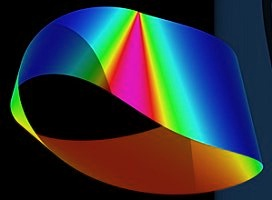

Python version "rgb2yuv":
Duration : 954.9 ms
Python version "yuv_scale":
Duration : 413.0 ms
Python version "yuv2rgb":
Duration : 973.5 ms
OUTPUT:


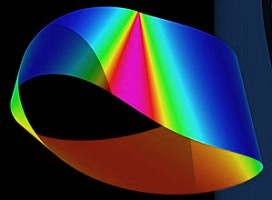

In [12]:
import cv2
import numpy as np
from PIL import Image, ImageOps

#Read input data file
rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3 = image_read('input.dat')

#Display input image
print('INPUT:')
dat2jpg('input.dat','input.jpg')
display_img('input.jpg')


#Restore input image
restore_width, restore_height, restore_ch1, restore_ch2, restore_ch3 = process_image(rgb_width, 
                                                                                     rgb_height, 
                                                                                     rgb_ch1, 
                                                                                     rgb_ch2, 
                                                                                     rgb_ch3, 
                                                                                     128, 128, 128)

#Write in output data file, R, G, B values restored
image_write(restore_width, restore_height, restore_ch1, restore_ch2, restore_ch3,'fh_output.dat')

#Display output image
print('OUTPUT:')
dat2jpg('fh_output.dat','fh_output.jpg')
display_img('fh_output.jpg')

### Comparison <a class="anchor" id="Comparison"></a>
[Top](#title)

In [13]:
import difflib
# my_diff: compare image text files 
# int ret = system("diff --brief -w test_data/output.dat test_data/output.golden.dat"); 
 
def my_diff(original_file,version_file):
    ret = 0
    with open(version_file, 'r') as fp1:
        with open(original_file, 'r') as fp0:
            fp0lines = fp0.readlines() 
            fp1lines = fp1.readlines() 
            first = False
            count = 0
            for x in range(len(fp0lines)):
                if fp0lines[x] != fp1lines[x]: 
                    count = count + 1
                    if not first:  
                        print("first diff at (", x,')',int(fp0lines[x]),int(fp1lines[x]))
                        first = True
            ret = count 
            print('{} {}'.format('output.golden.dat','fh_output.dat'),'| errors =', ret,'/',len(fp0lines))
    return ret

Right output:


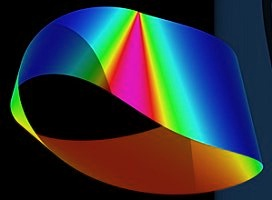

My output:


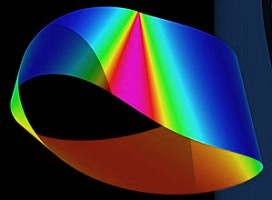

output.golden.dat fh_output.dat | errors = 0 / 163202


In [14]:
import cv2
import numpy as np
from PIL import Image, ImageOps

#Display the right image restored
print('Right output:')
display_img('output.golden.jpg')

#Display my output image restored
print('My output:')
display_img('fh_output.jpg')

ret = my_diff('fh_output.dat','output.dat')

## Tests PIL <a class="anchor" id="tests pil"></a>
[Top](#title)

largeur: 326 px
hauteur: 218 px
Balance des gris:


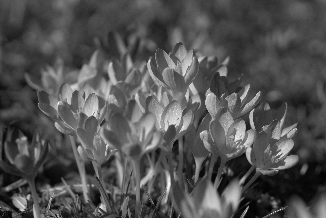

Noir et blanc:


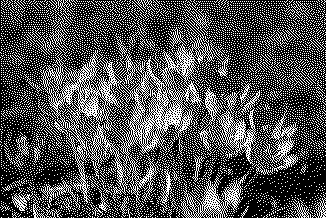

Rotation:


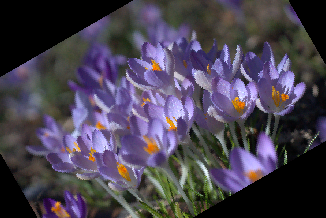

Taille modifiée:


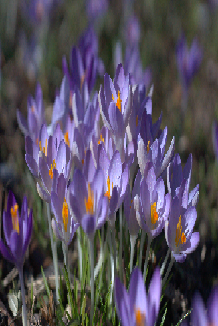

In [15]:
# example using PIL 

import numpy as np
from PIL import Image, ImageOps

image = Image.open('rawpy_demo_2.png')
largeur, hauteur = image.size
print('largeur:',largeur,'px')
print('hauteur:',hauteur,'px')

#Balance des gris
print('Balance des gris:')
imageG = image.convert('L')
display(imageG)
        
#Noir et blanc
print('Noir et blanc:')
imageNB = image.convert('1')
display(imageNB)

#Rotation
print('Rotation:')
image2 = image.rotate((30))
display(image2)

#Modifier la taille
print('Taille modifiée:')
image3 = image.resize((218, 326))
display(image3)


## Hard version <a class="anchor" id="AXI Stream DMA Methode"></a>
[Top](#title)

This part deals with the hard version of the YUV filter. The three functions of the filter: rgb2yuv, yuv_scale and yuv2rgb were created on Vivado and Vivado hls, then tested in this Jupyter Notebook. 

## YUV Scale <a class="anchor" id="yuv scale"></a>
[Top](#title)

This first part is about yuv_scale function. My custom IP takes as input a channel to transform the Y, U, V values to new values restored.

### Import overlay <a class="anchor" id="import yuv scale"></a>
[Top](#title)

In [75]:
from pynq import Overlay 
overlay = Overlay('design_scale.bit')

In [76]:
# Display the names of the overlay IP blocks
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['axi_dma_0', 'scale_y_0', 'processing_system7_0']


In [77]:
#Define my custom IP and my DMA

dma = overlay.axi_dma_0
dma_send = overlay.axi_dma_0.sendchannel
dma_recv = overlay.axi_dma_0.recvchannel

hls_ip = overlay.scale_y_0

In [78]:
#Get register offset of my parameter
def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

In [79]:
#Get parameters's memory offset
print('Parameters address offset :')
addr = get_register_offset(overlay, 'scale_y_0', 'Y_scale')
print('Y_Scale =', hex(addr))

Parameters address offset :
Y_Scale = 0x10


### Start my IP scale <a class="anchor" id="Start my IP scale"></a>
[Top](#title)

In [80]:
#View register map of my custom IP
hls_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  Y_scale = Register(Y_scale=0)
}

In [81]:
#Start my IP
CONTROL_REGISTER = 0x0
hls_ip.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

In [82]:
hls_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  Y_scale = Register(Y_scale=0)
}

### DMA Functions <a class="anchor" id="dma functions"></a>
[Top](#title)

In [83]:
from pynq import allocate
import numpy as np

width = 200
height = 272

#Write 128 for Y_Scale
hls_ip.write(0x10, 128)
print("Y_Scale =",hls_ip.read(0x10))

#data_size = width

Y_Scale = 128


In [84]:
# Send Input buffer to the DMA and recieve Output buffer
def dma_transfert(input_buffer, output_buffer):
    dma_send.transfer(input_buffer)
    dma_recv.transfer(output_buffer)
    dma_send.wait()
    dma_recv.wait()

In [85]:
#Read the channel to get Y, U, V values of one column
def read_channel(input_buffer, in_ch, offset):
    x = 0
    y = offset
    for x in range(height):
        input_buffer[x] = in_ch[y][x]

In [86]:
#Write in the channel Y, U, V values of one column
def write_channel(output_buffer, out_ch, offset):
    x = 0
    y = offset
    for x in range(height):
        out_ch[y][x] = output_buffer[x]

In [87]:
#Send values read to the dma and write values recieved
def process(in_ch1, out_ch1, scale, offset):
    input_buffer = allocate(shape=(height,), dtype=int)
    output_buffer = allocate(shape=(height,), dtype=int)
    hls_ip.write(0x10, scale)
    read_channel(input_buffer, in_ch1, offset)
    dma_transfert(input_buffer, output_buffer)
    write_channel(output_buffer, out_ch1, offset)
    del input_buffer, output_buffer    

In [88]:
#My new yuv_scale using my custom IP and my dma
def yuv_scale_dma (in_width, in_height, in_ch1, in_ch2, in_ch3, Y_scale, U_scale, V_scale):
    start = time.time()
    width = in_width
    height = in_height
    out_width = width 
    out_height = height   
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    j = 0
    for j in range(width):
        process(in_ch1, out_ch1, Y_scale, j) 
    j = 0
    for j in range(width):
        process(in_ch2, out_ch2, U_scale, j)
    j = 0
    for j in range(width):
        process(in_ch3, out_ch3, V_scale, j)
    end = time.time()
    # Delta time
    print('AXI Stream DMA version:')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

### Test Filter with  my IP <a class="anchor" id="Test Filter with my IP"></a>
[Top](#title)

INPUT:


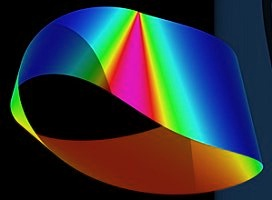

Python version "rgb2yuv":
Duration : 938.9 ms
AXI Stream DMA version:
Duration : 1972.4 ms
Python version "yuv2rgb":
Duration : 5540.4 ms


In [95]:
import cv2
import numpy as np
from PIL import Image, ImageOps

#Read input data file
rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3 = image_read('input.dat')

#Display input image
print('INPUT:')
dat2jpg('input.dat','input.jpg')
display_img('input.jpg')

#Convert R, G, B values to Y, U, V values
yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3 = rgb2yuv(rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3)
    
#Transform new Y, U, V values
scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 = yuv_scale_dma( yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3, 128, 128, 128 )

#Convert Y, U, V values to R, G, B values
out_width, out_height, out_ch1, out_ch2, out_ch3 = yuv2rgb( scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 )


OUTPUT:


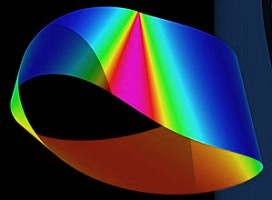

In [96]:
#write in output data file, new R, G, B values restored
image_write(out_width, out_height, out_ch1, out_ch2, out_ch3,'fh_output.dat')

print('OUTPUT:')
dat2jpg('fh_output.dat','fh_output.jpg')
display_img('fh_output.jpg')

In [97]:
#Compute differences between the right output and my output
ret = my_diff('fh_output.dat','output.dat')

output.golden.dat fh_output.dat | errors = 0 / 163202


## RGB2YUV <a class="anchor" id="rgb2yuv"></a>
[Top](#title)

This second part is about rgb2yuv function. My custom IP takes a channel as input to convert each R, G, B value to Y, U, V value.

### Import Overlay <a class="anchor" id="import rgb2yuv"></a>
[Top](#title)

In [99]:
from pynq import Overlay

overlay = Overlay("rgb2yuv.bit")

In [100]:
#Define my custom IP and my DMA
rgbYUV_ip = overlay.rgb2yuv_Y_0

dma0 = overlay.axi_dma_0
dma0_send = overlay.axi_dma_0.sendchannel
dma0_recv = overlay.axi_dma_0.recvchannel

dma1 = overlay.axi_dma_1
dma1_send = overlay.axi_dma_1.sendchannel
dma1_recv = overlay.axi_dma_1.recvchannel

dma2 = overlay.axi_dma_2
dma2_send = overlay.axi_dma_2.sendchannel
dma2_recv = overlay.axi_dma_2.recvchannel

In [101]:
#Get parameters's memory offset
print('Parameters address offset :')
addr = get_register_offset(overlay, 'rgb2yuv_Y_0', 'op')
print('op =', hex(addr))

Parameters address offset :
op = 0x10


### Start my IP rgb2yuv <a class="anchor" id="Start my IP rgb2yuv"></a>
[Top](#title)

In [102]:
#Start my IP and view register map
CONTROL_REGISTER = 0x0
rgbYUV_ip.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0
rgbYUV_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  op = Register(op=0)
}

### DMA Functions <a class="anchor" id="dma functions rgb2yuv"></a>
[Top](#title)

In [103]:
# Send Input buffer to the DMA and recieve Output buffer
def dma_transfert_rgb2yuv(in_buffer0, in_buffer1, in_buffer2, out_buffer0, out_buffer1, out_buffer2):
    dma0_send.transfer(in_buffer0)
    dma1_send.transfer(in_buffer1)
    dma2_send.transfer(in_buffer2)

    dma0_recv.transfer(out_buffer0)
    dma1_recv.transfer(out_buffer1)
    dma2_recv.transfer(out_buffer2)

    dma0_send.wait()
    dma1_send.wait()
    dma2_send.wait()

    dma0_recv.wait()
    dma1_recv.wait()
    dma2_recv.wait()

In [104]:
#Send values read to the dma and write values recieved
def process_rgb2yuv(in_ch0, in_ch1, in_ch2, out_ch0, out_ch1, out_ch2, offset):
    input_buffer0 = allocate(shape=(height,), dtype=int)
    input_buffer1 = allocate(shape=(height,), dtype=int)
    input_buffer2 = allocate(shape=(height,), dtype=int)

    output_buffer0 = allocate(shape=(height,), dtype=int)
    output_buffer1 = allocate(shape=(height,), dtype=int)
    output_buffer2 = allocate(shape=(height,), dtype=int)
    j = offset
    read_channel(input_buffer0, in_ch0, j)
    read_channel(input_buffer1, in_ch1, j)
    read_channel(input_buffer2, in_ch2, j)

    rgbYUV_ip.write(0x10, 0)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    write_channel(output_buffer0, out_ch0, j)

    rgbYUV_ip.write(0x10, 1)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    write_channel(output_buffer1, out_ch1, j)

    rgbYUV_ip.write(0x10, 2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    write_channel(output_buffer2, out_ch2, j) 
    
    del input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2

In [105]:
#My new rgb2yuv using my custom IP and my dma
def rgb2yuv_dma (in_width, in_height, in_ch1, in_ch2, in_ch3):
    start = time.time()
    width = in_width
    height = in_height
    out_width = width     
    out_height = height 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    for j in range (width):    
        process_rgb2yuv(in_ch1, in_ch2, in_ch3, out_ch1, out_ch2, out_ch3, j)
    end = time.time()
    # Delta time
    print('AXI Stream DMA version:')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

### Test Filter with  my IP <a class="anchor" id="Test Filter with my IP rgb2yuv"></a>
[Top](#title)

INPUT:


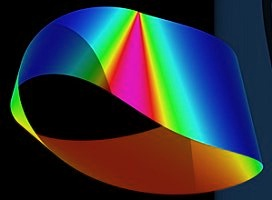

AXI Stream DMA version:
Duration : 3939.0 ms
Python version "yuv_scale":
Duration : 1562.2 ms
Python version "yuv2rgb":
Duration : 5435.7 ms


In [106]:
import cv2
import numpy as np
from PIL import Image, ImageOps

#Read input data file
rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3 = image_read('input.dat')

#Display input image
print('INPUT:')
dat2jpg('input.dat','input.jpg')
display_img('input.jpg')

#Convert R, G, B values to Y, U, V values
yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3 = rgb2yuv_dma(rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3)

#Transform new Y, U, V values
scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 = yuv_scale( yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3, 128, 128, 128 )

#Convert Y, U, V values to R, G, B values
out_width, out_height, out_ch1, out_ch2, out_ch3 = yuv2rgb( scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 )

OUTPUT:


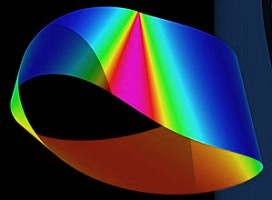

In [107]:
#Write in output data file, new R, G, B values restored
image_write(out_width, out_height, out_ch1, out_ch2, out_ch3,'fh_output.dat')

print('OUTPUT:')
dat2jpg('fh_output.dat','fh_output.jpg')
display_img('fh_output.jpg')

In [108]:
#Compute differences between the right output and my output
ret = my_diff('fh_output.dat','output.dat')

output.golden.dat fh_output.dat | errors = 0 / 163202


## YUV2RGB <a class="anchor" id="yuv2rgb"></a>
[Top](#title)

This second part is about yuv2rgb function. My custom IP takes a channel as input to convert each Y, U, V value to R, G, B value.

### Import Overlay <a class="anchor" id="import yuv2rgb"></a>
[Top](#title)

In [110]:
from pynq import Overlay

overlay = Overlay("yuv2rgb.bit")

In [111]:
# Display the names of the overlay IP blocks
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['axi_dma_0', 'axi_dma_1', 'axi_dma_2', 'yuv2rgb_0', 'processing_system7_0']


In [112]:
yuv_ip = overlay.yuv2rgb_0

dma0 = overlay.axi_dma_0
dma0_send = overlay.axi_dma_0.sendchannel
dma0_recv = overlay.axi_dma_0.recvchannel

dma1 = overlay.axi_dma_1
dma1_send = overlay.axi_dma_1.sendchannel
dma1_recv = overlay.axi_dma_1.recvchannel

dma2 = overlay.axi_dma_2
dma2_send = overlay.axi_dma_2.sendchannel
dma2_recv = overlay.axi_dma_2.recvchannel

### Start my IP yuv2rgb <a class="anchor" id="Start my IP yuv2rgb"></a>
[Top](#title)

In [113]:
CONTROL_REGISTER = 0x0
yuv_ip.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0
yuv_ip.register_map

RegisterMap {
  CTRL = Register(AP_START=1, AP_DONE=0, AP_IDLE=0, AP_READY=0, RESERVED_1=0, AUTO_RESTART=1, RESERVED_2=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED=0),
  op = Register(op=0)
}

### DMA Functions <a class="anchor" id="dma functions yuv2rgb"></a>
[Top](#title)

In [114]:
#Send values read to the dma and write values recieved
def process_yuv2rgb(in_ch0, in_ch1, in_ch2, out_ch0, out_ch1, out_ch2, offset):
    input_buffer0 = allocate(shape=(height,), dtype=int)
    input_buffer1 = allocate(shape=(height,), dtype=int)
    input_buffer2 = allocate(shape=(height,), dtype=int)

    output_buffer0 = allocate(shape=(height,), dtype=int)
    output_buffer1 = allocate(shape=(height,), dtype=int)
    output_buffer2 = allocate(shape=(height,), dtype=int)
    j = offset
    read_channel(input_buffer0, in_ch0, j)
    read_channel(input_buffer1, in_ch1, j)
    read_channel(input_buffer2, in_ch2, j)

    yuv_ip.write(0x10, 0)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    write_channel(output_buffer0, out_ch0, j)

    yuv_ip.write(0x10, 1)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    write_channel(output_buffer1, out_ch1, j)

    yuv_ip.write(0x10, 2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    dma_transfert_rgb2yuv(input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2)
    write_channel(output_buffer2, out_ch2, j) 
    
    del input_buffer0, input_buffer1, input_buffer2, output_buffer0, output_buffer1, output_buffer2

In [115]:
#My new rgb2yuv using my custom IP and my dma
def yuv2rgb_dma (in_width, in_height, in_ch1, in_ch2, in_ch3):
    start = time.time()
    width = in_width
    height = in_height
    out_width = width     
    out_height = height 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    for j in range (width):    
        process_yuv2rgb(in_ch1, in_ch2, in_ch3, out_ch1, out_ch2, out_ch3, j)  
    end = time.time()
    # Delta time
    print('AXI Stream DMA version:')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

### Test Filter with  my IP <a class="anchor" id="Test Filter with my IP yuv2rgb"></a>
[Top](#title)

INPUT:


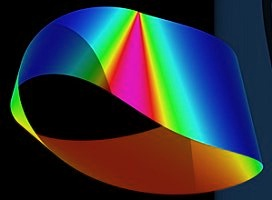

Python version "rgb2yuv":
Duration : 963.0 ms
Python version "yuv_scale":
Duration : 399.7 ms
AXI Stream DMA version:
Duration : 3788.9 ms


In [116]:
import cv2
import numpy as np
from PIL import Image, ImageOps

#Read input data file
rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3 = image_read('input.dat')

#Display input image
print('INPUT:')
dat2jpg('input.dat','input.jpg')
display_img('input.jpg')

#Convert R, G, B values to Y, U, V values
yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3 = rgb2yuv(rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3)

#Transform new Y, U, V values
scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 = yuv_scale( yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3, 128, 128, 128 )

#Convert Y, U, V values to R, G, B values
out_width, out_height, out_ch1, out_ch2, out_ch3 = yuv2rgb_dma( scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 )

OUTPUT:


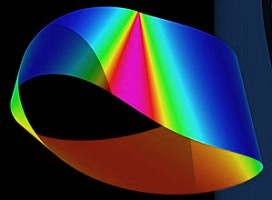

In [117]:
#Write in output data file, new R, G, B values restored
image_write(out_width, out_height, out_ch1, out_ch2, out_ch3,'fh_output.dat')

print('OUTPUT:')
dat2jpg('fh_output.dat','fh_output.jpg')
display_img('fh_output.jpg')

In [118]:
#Compute differences between the right output and my output
ret = my_diff('fh_output.dat','output.dat')

output.golden.dat fh_output.dat | errors = 0 / 163202
